# 1. Import Libraries 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2

In [2]:
train_csv_path = r'..\data\train_test_csv\train_data.csv'
test_csv_path = r'..\data\train_test_csv\test_data.csv'
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

# Display the number of imported images
print(f"Number of training images: {len(train_df)}")
print(f"Number of test images: {len(test_df)}")

Number of training images: 2641
Number of test images: 294


In [3]:
train_df.Label.value_counts()

Label
airplanes            720
Motorbikes           718
BACKGROUND_Google    420
Faces_easy           392
Faces                391
Name: count, dtype: int64

In [4]:
test_df.Label.value_counts()

Label
Motorbikes           80
airplanes            80
BACKGROUND_Google    47
Faces                44
Faces_easy           43
Name: count, dtype: int64

In [5]:
train_df.head()

HOG_0     HOG_1     HOG_2     HOG_3     HOG_4     HOG_5     HOG_6  \
0  0.027177  0.025653  0.037031  0.089839  0.168321  0.174550  0.248641   
1  0.235837  0.038368  0.031238  0.026915  0.073421  0.011923  0.004732   
2  0.140965  0.000000  0.000000  0.000000  0.001747  0.000000  0.000000   
3  0.382552  0.016438  0.007117  0.002574  0.015769  0.002730  0.017733   
4  0.305484  0.080676  0.015355  0.063711  0.072808  0.034462  0.012741   

      HOG_7     HOG_8     HOG_9  ...  HOG_8091  HOG_8092  HOG_8093  HOG_8094  \
0  0.248641  0.171540  0.015715  ...  0.030575  0.015245  0.034649  0.141972   
1  0.000100  0.184045  0.337206  ...  0.117988  0.004348  0.007640  0.002928   
2  0.000000  0.141014  0.159202  ...  0.364948  0.178828  0.092794  0.067782   
3  0.050059  0.382552  0.382552  ...  0.349882  0.008987  0.003086  0.000883   
4  0.043839  0.305484  0.305484  ...  0.266868  0.034736  0.031162  0.232690   

   HOG_8095  HOG_8096  HOG_8097  HOG_8098  HOG_8099              Label  
0  0.307208  0.307208  0.157726  0.040761  0.040718  BACKGROUND_Google  
1  0.005445  0.002255  0.010032  0.004228  0.122178         Motorbikes  
2  0.066389  0.040597  0.156272  0.189141  0.364948          airplanes  
3  0.029269  0.000000  0.008355  0.011984  0.349882         Motorbikes  
4  0.239519  0.225903  0.266868  0.225866  0.266868          airplanes  

[5 rows x 8101 columns]

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

# Creating Labelled Unlabelled Data

In [7]:
from sklearn.model_selection import train_test_split

def partition_and_make_unlabeled(df, test_size=0.5, random_state=None):
    labeled_df1, labeled_df2 = train_test_split(df, test_size=test_size, stratify=df['Label'], random_state=random_state)
    unlabeled_df = labeled_df2.drop('Label', axis=1)
    
    return labeled_df1, labeled_df2, unlabeled_df

In [8]:
labeled_df1, labeled_df2, unlabeled_df = partition_and_make_unlabeled(train_df, test_size=0.80, random_state=42)

In [9]:
print(f"Size of labelled df: {len(labeled_df1)}")
print(f"Size of unlabelled df: {len(unlabeled_df)}")

Size of labelled df: 132
Size of unlabelled df: 2509


# Model Builiding

#### Training Forest and Trees

In [10]:
def train_rf(X, n_estimators=10):
    rf = RandomForestClassifier(n_estimators=n_estimators, criterion='gini', max_depth=5, oob_score = True, random_state = 0)
    rf.fit(X.iloc[:,:-1].values, X.iloc[:,-1].values)
    return rf

# Model Training

In [11]:
forest = train_rf(labeled_df1, n_estimators=50)

# Model Evaluation 

In [12]:
y_pred = forest.predict(test_df.iloc[:,:-1].values)
y_true = test_df.values[:,-1]
y_true = y_true.astype(int)
y_pred = y_pred.astype(int)

In [13]:
labels_num = label_encoder.inverse_transform(test_df['Label'])
labels = np.unique(labels_num)
labels = list(labels)

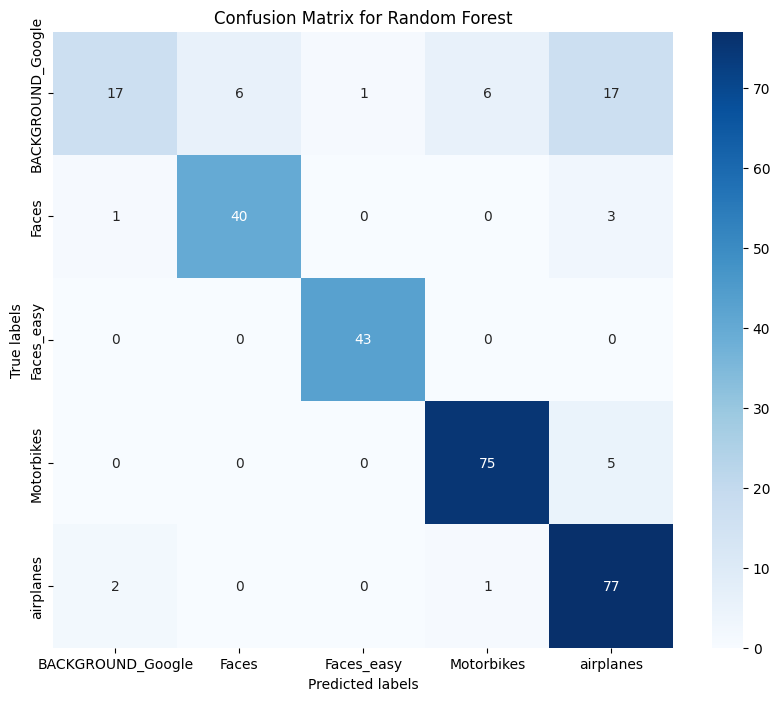

In [14]:
def plot_confusion_matrix(y_true, y_pred, label_text, label_num):
    cm = confusion_matrix(y_true, y_pred, labels=label_num)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_text, yticklabels=label_text)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for Random Forest')
    plt.show()

plot_confusion_matrix(y_true, y_pred, labels, np.unique(train_df.values[:,-1]))

In [15]:
def metrics(y_true, y_pred):

    confusion_matrix = np.zeros((y_true.max() + 1, y_true.max() + 1))
    for i in range(len(y_true)):
        confusion_matrix[y_true[i], y_pred[i]] += 1

    # precision and recall
    precision = []
    recall = []
    for i in range(y_true.max() + 1):
        tp = confusion_matrix[i, i]
        fp = np.sum(confusion_matrix[:, i]) - tp
        fn = np.sum(confusion_matrix[i, :]) - tp
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    precisions = np.mean(precision)
    recalls = np.mean(recall)

    # Calculating accuracy
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)

    # Calculating F1 score
    f1_score = 2 * (precisions * recalls) / (precisions + recalls) if (precisions + recalls) != 0 else 0

    return precisions, recalls, precision, recall, accuracy, f1_score

precision , recall, precision_list, recall_list, accuracy, f1_score = metrics(y_true, y_pred)

In [16]:
test_size = len(test_df)
data = {
    'Dataset': ['Caltech-101'],
    'Test Size': [test_size]
}

df = pd.DataFrame(data)

In [17]:
df['Precision'] = precision
df['Recall'] = recall
df['Accuracy'] = accuracy
df['F1 Score'] = f1_score
df

Dataset  Test Size  Precision    Recall  Accuracy  F1 Score
0  Caltech-101        294   0.873275  0.834159  0.857143  0.853269

In [18]:
df2 = pd.DataFrame()
df2["Category"] = labels
df2["Precision"] = precision_list
df2["Recall"] = recall_list
df2

Category  Precision    Recall
0  BACKGROUND_Google   0.850000  0.361702
1              Faces   0.869565  0.909091
2         Faces_easy   0.977273  1.000000
3         Motorbikes   0.914634  0.937500
4          airplanes   0.754902  0.962500